# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# general libraries
import glob
import os
import pathlib
import site
import sys
import warnings
# data handling libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning libraries
import gpytorch
from sklearn import gaussian_process as gp
from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import metrics
from sklearn import pipeline
import torch

# Basic exploration with simple libraries (scikit-learn)

The non-production code in this notebook is used to explore the data and create a dataset for training machine learning models. It is not intended for production use.  
As a primer, we've already decided that gaussian processes are the best choice for our problem, since we don't have enough data to train a deep learning model.

In [4]:
fname_spatial = '../../pamir-CryoGrid/forcing/spatial_variables-710w365s750e400n-100m.zarr'
fname_training = '../data/training/training_data-active_layer_thickness--k1500-pamir_N180-exp1.parquet'

y_name = 'active_layer_thickness'
x_names = [
    'altitude',
    'slope_angle',
    'aspect',
    'albedo',
    'emissivity',
    'temperature',
    'precipitation'
]

In [5]:
df = pd.read_parquet(fname_training)

In [15]:
rename_dict = {
    'albedo_modis': 'albedo',
    'emissivity_aster': 'emissivity',
}
ds_inference = xr.open_zarr(fname_spatial).rename(rename_dict).isel(y=slice(1500, 2000), x=slice(1500, 2000))
df_inference = ds_inference[x_names].to_dataframe().dropna()

In [8]:
model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    gp.GaussianProcessRegressor(
        kernel=gp.kernels.RBF(length_scale=0.01),
        alpha=1e-4,
        n_restarts_optimizer=10,
        normalize_y=True,
    )
)

In [9]:
model.fit(
    df[x_names],
    df[y_name])

model.score(
    df[x_names],
    df[y_name])

0.9999999848377018

In [16]:
yhat = model.predict(
    df_inference[x_names],
)

da_yhat = pd.Series(
    yhat,
    index=df_inference.index,
    name='yhat'
).to_xarray()

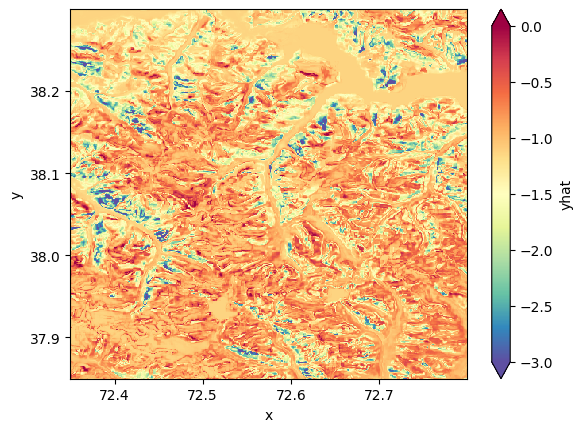

In [23]:
da_yhat.plot.imshow(vmax=0, vmin=-3, robust=True, cmap='Spectral_r')